In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#from bokeh.plotting import figure, show, output_notebook
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use("ggplot") # Set plot style
%matplotlib inline

In [2]:
import pandas as pd
### Read the data and parse the date columns into datetime format, as well as set the date columns as indexes, 
###the dataset should have been 128544 rows, but is currently 128156 rows, there are missing values
df=pd.read_csv(r'C:\\Users\\86130\00.Project\00.Data Preprocessing\Resample Median data fill 15mins.csv')

In [3]:
df.head()

,datatime,total power usage（kw）
0,2018-01-01 00:00:00,244033.7682
1,2018-01-01 00:15:00,232720.6402
2,2018-01-01 00:30:00,231685.6891
3,2018-01-01 00:45:00,227581.3317
4,2018-01-01 01:00:00,233482.4269


In [4]:
# 计算均值和标准差
mean_power = df['total power usage（kw）'].mean()
std_power = df['total power usage（kw）'].std()

# 计算异常值的上下界限
lower_bound = mean_power - 3 * std_power
upper_bound = mean_power + 3 * std_power
outliers = df[(df['total power usage（kw）'] < lower_bound) | (df['total power usage（kw）'] > upper_bound)]

In [5]:
print(outliers)

                   datatime  total power usage（kw）
13484   2018-05-21 11:00:00            357240.3162
13488   2018-05-21 12:00:00            352868.3437
13492   2018-05-21 13:00:00            351089.1129
13496   2018-05-21 14:00:00            355503.3092
13500   2018-05-21 15:00:00            355824.1600
...                     ...                    ...
126367  2021-08-09 07:45:00              3294.5409
126368  2021-08-09 08:00:00              3655.8173
126369  2021-08-09 08:15:00              3497.2847
126370  2021-08-09 08:30:00             14913.9532
126371  2021-08-09 08:45:00             56443.8603

[333 rows x 2 columns]


In [6]:
# 计算均值和标准差
#mean_power = df['total power usage（kw）'].mean()
#std_power = df['total power usage（kw）'].std()

# 计算异常值的上下界限
#lower_bound = mean_power - 3 * std_power
#upper_bound = mean_power + 3 * std_power

# 计算中位数
median_power = df['total power usage（kw）'].median()

# 用中位数替换异常值
df['total power usage（kw）'] = df['total power usage（kw）'].apply(lambda x: median_power if x < lower_bound or x > upper_bound else x)

In [7]:
df.head()

,datatime,total power usage（kw）
0,2018-01-01 00:00:00,244033.7682
1,2018-01-01 00:15:00,232720.6402
2,2018-01-01 00:30:00,231685.6891
3,2018-01-01 00:45:00,227581.3317
4,2018-01-01 01:00:00,233482.4269


In [8]:
df["datatime"] = pd.to_datetime(df["datatime"])

#Date features
df["hour"] = df["datatime"].dt.hour
df["day"] = df["datatime"].dt.dayofweek
df["month"] = df["datatime"].dt.month
df["year"] = df["datatime"].dt.year
df["quarter"] = df["datatime"].dt.quarter
df["day-of-year"] = df["datatime"].dt.dayofyear
df["day-of-month"] = df["datatime"].dt.day
df["week-of-year"] = df["datatime"].dt.weekofyear

df["Drop_me"] = df["datatime"].dt.strftime("%m-%d")

df.index = df["datatime"]
df = df.drop(["datatime"],axis=1)

C:\Users\86130\AppData\Local\Temp\ipykernel_18712\2265729984.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week-of-year"] = df["datatime"].dt.weekofyear


In [9]:
df.head()

,total power usage（kw）,hour,day,month,year,quarter,day-of-year,day-of-month,week-of-year,Drop_me
datatime,,,,,,,,,,
2018-01-01 00:00:00,244033.7682,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:15:00,232720.6402,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:30:00,231685.6891,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:45:00,227581.3317,0,0,1,2018,1,1,1,1,01-01
2018-01-01 01:00:00,233482.4269,1,0,1,2018,1,1,1,1,01-01


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.head()

,total power usage（kw）,hour,day,month,year,quarter,day-of-year,day-of-month,week-of-year,Drop_me
datatime,,,,,,,,,,
2018-01-01 00:00:00,244033.7682,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:15:00,232720.6402,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:30:00,231685.6891,0,0,1,2018,1,1,1,1,01-01
2018-01-01 00:45:00,227581.3317,0,0,1,2018,1,1,1,1,01-01
2018-01-01 01:00:00,233482.4269,1,0,1,2018,1,1,1,1,01-01


Text(0.0, 1.0, 'Power distribution')

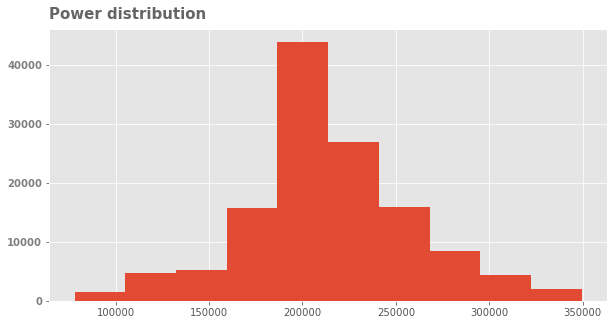

In [7]:
ax, fig = plt.subplots(figsize=(10,5))

plt.hist(df["total power usage（kw）"])

plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("",alpha=0.75, weight="bold")
plt.ylabel("",alpha=0.75, weight="bold")

plt.title("Power distribution", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

In [8]:
df.to_csv(r"C:\Users\86130\00.Project\00.Data Preprocessing\EDA-15mins.csv",index=True,header=True) 

C:\Users\86130\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\86130\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\86130\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

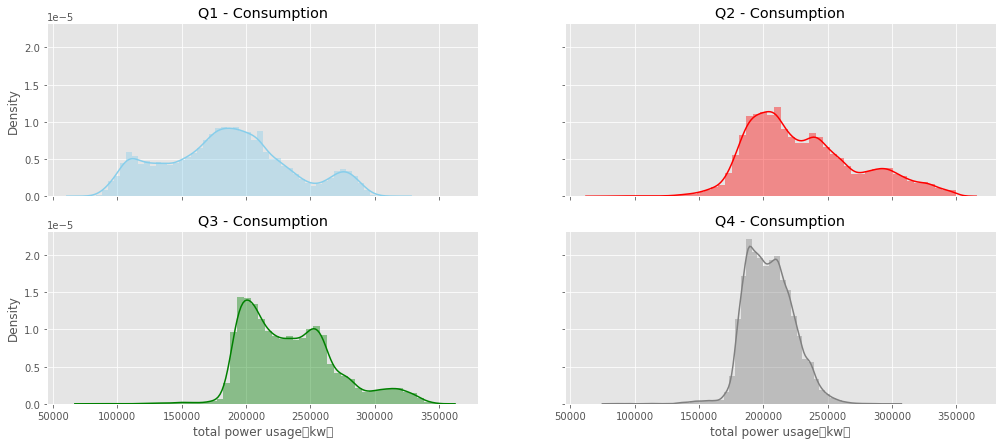

In [9]:
#Data prep
Q1 = df[df["quarter"]==1]
Q2 = df[df["quarter"]==2]
Q3 = df[df["quarter"]==3]
Q4 = df[df["quarter"]==4]

#Plot
fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["total power usage（kw）"],color="skyblue", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["total power usage（kw）"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["total power usage（kw）"],color="green", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["total power usage（kw）"],color="gray", ax=axes[1,1]).set_title("Q4 - Consumption")

del Q1, Q2, Q3, Q4

Text(0.0, 1.0, 'Mean daily Power Load Data')

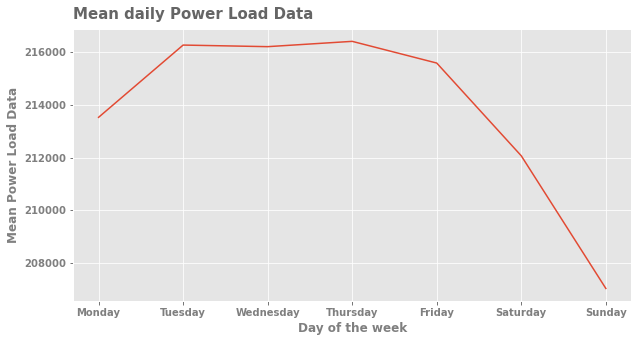

In [10]:
#Data prep
mean_per_day = df.groupby("day")["total power usage（kw）"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean Power Load Data",alpha=0.75, weight="bold")

plt.title("Mean daily Power Load Data", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

#del mean_per_day

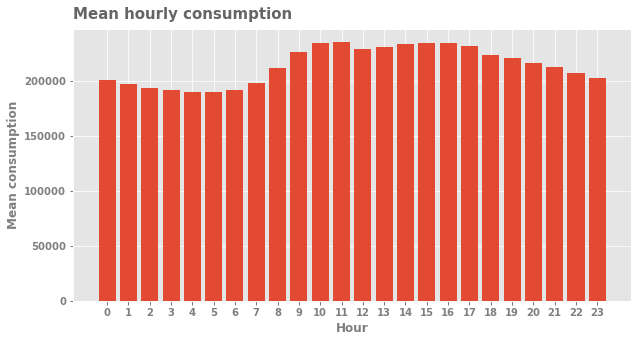

In [11]:
#Data
mean_per_hour = df.groupby("hour")["total power usage（kw）"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Text(0.0, 1.0, 'Consumption over time')

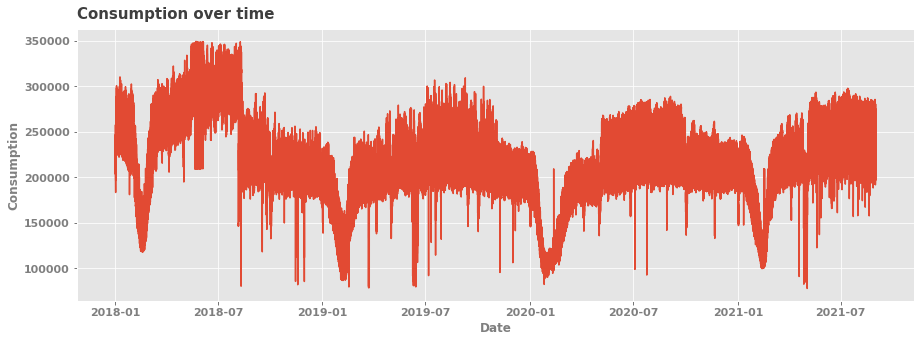

In [12]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(df.index,df["total power usage（kw）"])

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Consumption over time", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [13]:
#Be ready for some bruteforce if functions
def feature_holidays(row):

    if row["Drop_me"] == "01-01":
        return "New Year"
    if row["Drop_me"] == "04-07":
        return "Ind Day"
    if row["Drop_me"] == "11-28":
        return "Thanksgiving"
    if row["Drop_me"] == "12-25":
        return "Christmas"
    return 'Other'
def feature_worktime(row):
    if row["hour"] > 7 & row["hour"] <= 17:
        return "Worktime"
    return "NonWorkTime"
def feature_peak(row):
    if row["hour"] > 7 & row["hour"] <= 22:
        return "Peak"
    return "NonPeak"
def feature_weekend(row):
    if row["day"] == 5 or row["day"] == 6:
        return "Weekend"
    return "NonWeekend"

In [14]:
df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Work"] = df.apply(lambda row: feature_worktime(row), axis=1)
df["Peak"] = df.apply(lambda row: feature_peak(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

In [15]:
df = df.drop(["Drop_me"],axis=1)

C:\Users\86130\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\86130\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\86130\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.draw()
C:\Users\86130\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.draw()
C:\Users\86130\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86130\anaconda3\lib\site-packages\IPython\core\pylabtoo

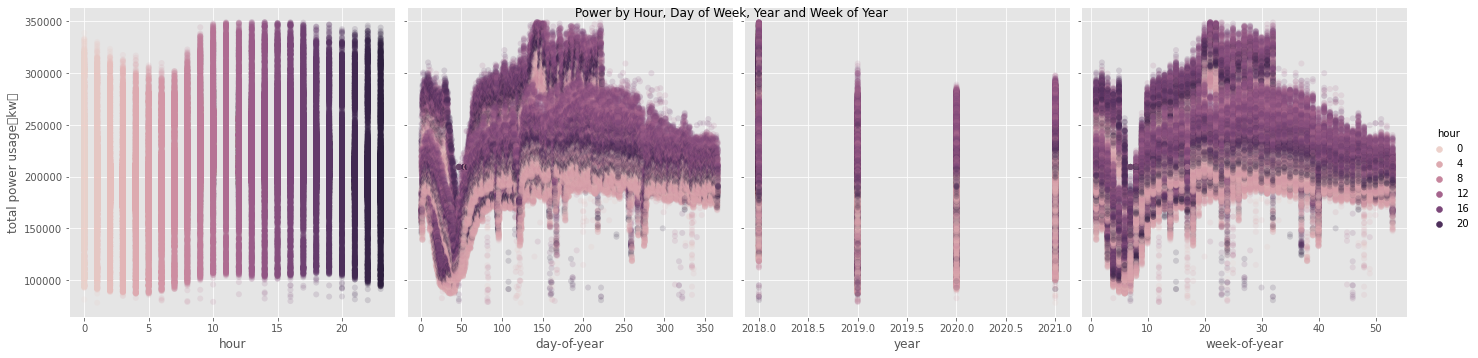

In [20]:
sns.pairplot(df.dropna(),
             hue='hour',
             x_vars=['hour','day-of-year',
                     'year','week-of-year'],
             y_vars='total power usage（kw）',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power by Hour, Day of Year, Year and Week of Year')
plt.show()

In [21]:
dummies = pd.get_dummies(df[["Holiday","Peak","Work","Weekend"]],prefix="Dummy")
df = df.join(dummies,lsuffix="_left")
df = df.drop(df[["Holiday","Peak","Work","Weekend"]], axis=1)

KeyError: "None of [Index(['Holiday', 'Peak', 'Work', 'Weekend'], dtype='object')] are in the [columns]"

In [30]:
train_test_date = "07-01-2020"
consum_test = df[df.index > train_test_date].copy()
consum_train = df[df.index <= train_test_date].copy()

In [31]:
def lag_features(lag_dataset,period_list):

    temp_data = lag_dataset["total power usage（kw）"]

    for period in period_list:

        lag_dataset["lag_consumption_{}".format(period)] = temp_data.shift(period)
        lag_dataset["mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lag_dataset["max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lag_dataset["min_rolling_{}".format(period)] = temp_data.rolling(period).min()

    for column in lag_dataset.columns[20:]:

        lag_dataset[column] = lag_dataset[column].fillna(lag_dataset.groupby("hour")["total power usage（kw）"].transform("mean"))
    
    return lag_dataset

In [32]:
consum_train = lag_features(consum_train,[7,14,30])

consum_test = lag_features(consum_test,[7,14,30])

Text(0.0, 1.0, 'Train - Test Split')

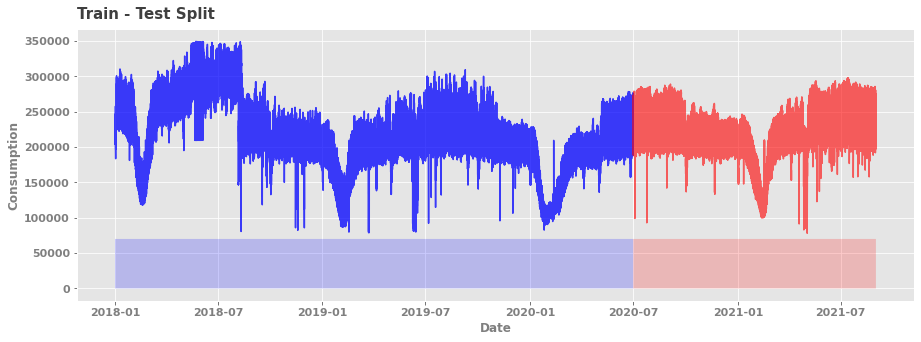

In [33]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 70000

plt.plot(consum_train.index,consum_train["total power usage（kw）"],color="blue", alpha=0.75)
plt.fill_between(consum_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(consum_test.index,consum_test["total power usage（kw）"], color = "red", alpha=0.60)
plt.fill_between(consum_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [34]:
df.head()

,total power usage（kw）,hour,day,month,year,quarter,day-of-year,day-of-month,week-of-year,Dummy_Christmas,Dummy_Ind Day,Dummy_New Year,Dummy_Other,Dummy_Thanksgiving,Dummy_NonPeak,Dummy_Peak,Dummy_NonWorkTime,Dummy_Worktime,Dummy_NonWeekend,Dummy_Weekend
datatime,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,244033.7682,0,0,1,2018,1,1,1,1,0,0,1,0,0,1,0,1,0,1,0
2018-01-01 00:15:00,232720.6402,0,0,1,2018,1,1,1,1,0,0,1,0,0,1,0,1,0,1,0
2018-01-01 00:30:00,231685.6891,0,0,1,2018,1,1,1,1,0,0,1,0,0,1,0,1,0,1,0
2018-01-01 00:45:00,227581.3317,0,0,1,2018,1,1,1,1,0,0,1,0,0,1,0,1,0,1,0
2018-01-01 01:00:00,233482.4269,1,0,1,2018,1,1,1,1,0,0,1,0,0,1,0,1,0,1,0


In [35]:
#Train - Test
X_train = consum_train.drop("total power usage（kw）", axis=1) 
y_train = consum_train["total power usage（kw）"]
X_test = consum_test.drop("total power usage（kw）", axis=1)
y_test = consum_test["total power usage（kw）"]

In [36]:
#XGBoost

xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)

C:\Users\86130\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

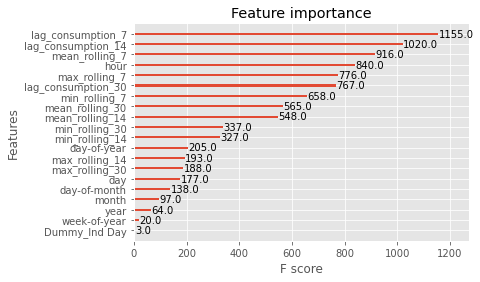

In [37]:
plot_importance(xgd_reg)

In [38]:
consum_test["Prediction"] = xgd_reg.predict(X_test)

Text(0.0, 1.0, 'Predicted Power Load')

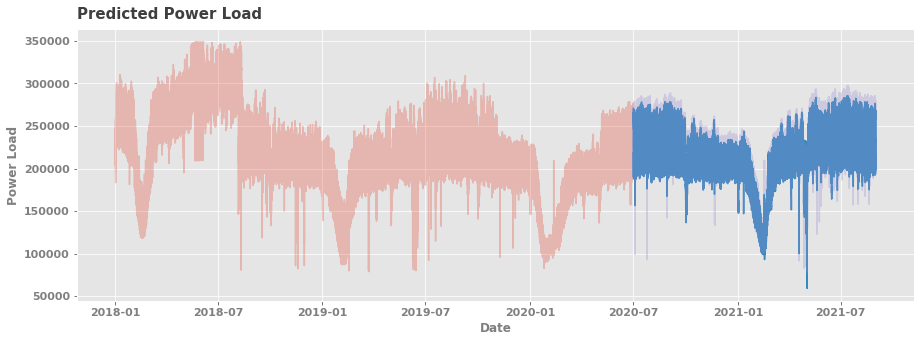

In [39]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["total power usage（kw）"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["total power usage（kw）"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Power Load", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted Power Load", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Text(0.0, 1.0, 'Predicted Power Load')

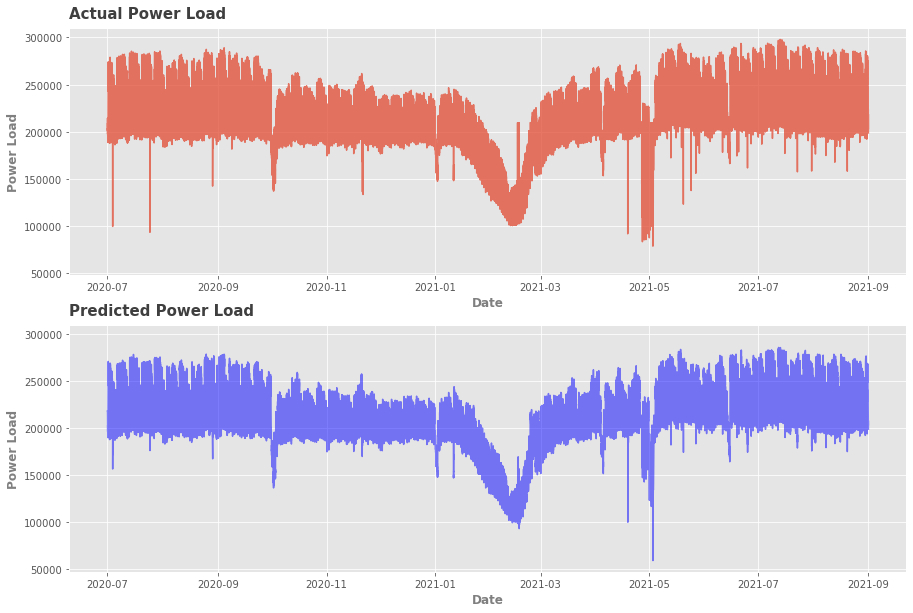

In [41]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(consum_test.index,consum_test["total power usage（kw）"],alpha=0.75)
ax2.plot(consum_test.index,consum_test["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Power Load", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Power Load", alpha=0.75, weight="bold")

ax1.set_title("Actual Power Load", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted Power Load", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [42]:
mean_sq = mean_squared_error(y_test,xgd_reg.predict(X_test))
rmse = np.sqrt(mean_sq)

mean_abs_sq = mean_absolute_error(y_test,xgd_reg.predict(X_test))

print("Root Mean Squared Error : {}".format(rmse))
print("Mean Absolute Error : {}".format(mean_abs_sq))

Root Mean Squared Error : 7119.669722757972
Mean Absolute Error : 5199.039027998371


In [43]:
# Worst Hour Prediction
consum_test["Difference"] = np.abs(consum_test["total power usage（kw）"] - consum_test["Prediction"])
consum_test["Difference"].sort_values(ascending=False)[:10]

datatime
2020-07-24 20:00:00    110566.247750
2021-04-18 22:15:00    105101.752575
2021-04-19 00:15:00     97650.127650
2021-02-16 23:15:00     97306.346562
2020-11-21 10:15:00     96997.363725
2021-05-24 12:15:00     95842.474425
2021-04-27 04:15:00     94838.851225
2021-04-19 00:30:00     86188.746688
2021-05-03 03:15:00     85527.384787
2021-02-16 03:00:00     83815.502812
Name: Difference, dtype: float64

ConversionError: Failed to convert value(s) to axis units: '2020-11-20 10:15:00 '

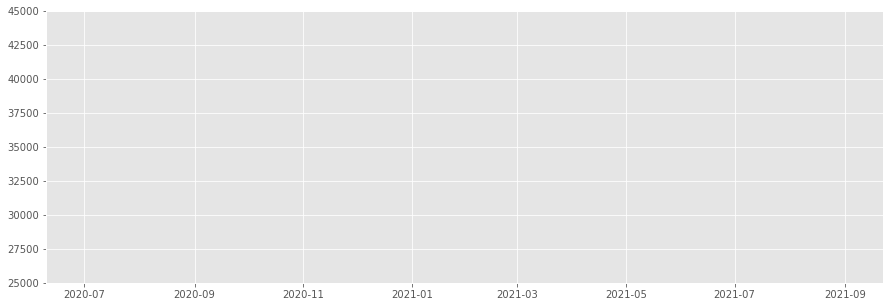

In [51]:
fig,ax= plt.subplots(figsize=(15,5))


ax.plot(consum_test.index,consum_test["total power usage（kw）"],label="Actual")
ax.plot(consum_test.index,consum_test["Prediction"],alpha=.5,zorder=10,label="Predicted")

consum = consum_test["total power usage（kw）"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum,pred, facecolor="green", alpha=.2,label="Difference")

ax.set_ylim(25000, 45000)
ax.set_xbound(lower="2020-11-20 10:15:00 ", upper="2020-11-20 20:15:00 ")

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Power Load ", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Period with the worst hourly prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
plt.legend()